In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv('final_with_covid_AS.csv')
data.head()

,CountCases,BedDys,BeddystoCC,Severity,DiedCases,DiedBdDys,Hsptlsns,April,August,December,...,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Y2021,CovidPrd
0,17,133,7.823529,75,4,9,13,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,13,372,28.615385,63,4,34,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,106,13.250000,48,4,13,4,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,45,218,4.844444,153,3,24,42,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,24,238,9.916667,90,3,8,21,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [3]:
filtered_data5 = data[data['Pedestrian'] == 1]
filtered_data5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6086 entries, 0 to 54037
Data columns (total 58 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CountCases       6086 non-null   int64  
 1   BedDys           6086 non-null   int64  
 2   BeddystoCC       6086 non-null   float64
 3   Severity         6086 non-null   int64  
 4   DiedCases        6086 non-null   int64  
 5   DiedBdDys        6086 non-null   int64  
 6   Hsptlsns         6086 non-null   int64  
 7   April            6086 non-null   int64  
 8   August           6086 non-null   int64  
 9   December         6086 non-null   int64  
 10  February         6086 non-null   int64  
 11  January          6086 non-null   int64  
 12  July             6086 non-null   int64  
 13  June             6086 non-null   int64  
 14  March            6086 non-null   int64  
 15  May              6086 non-null   int64  
 16  November         6086 non-null   int64  
 17  October          6

In [4]:
num_bins = 2

bed_days_min = filtered_data5['Severity'].min()
bed_days_max = filtered_data5['Severity'].max()

bin_width = (bed_days_max - bed_days_min) / num_bins
bins = [bed_days_min + i * bin_width for i in range(num_bins + 1)]

def bin_function(x):
    for i in range(1, len(bins)):
        if x <= bins[i]:
            return i - 1
    return i

filtered_data5['Bed_days_category'] = filtered_data5['Severity'].apply(bin_function)

<ipython-input-4-b3c71e766615>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data5['Bed_days_category'] = filtered_data5['Severity'].apply(bin_function)


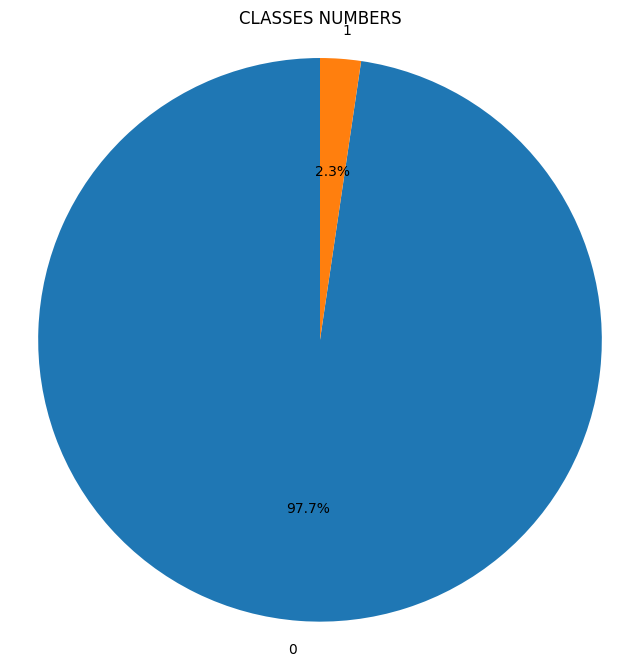

In [5]:
import matplotlib.pyplot as plt

value_counts = filtered_data5['Bed_days_category'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('CLASSES NUMBERS')
plt.show()

In [10]:
from sklearn.metrics import f1_score

def find_best_threshold(probs, y_true):
    best_threshold = 0.0
    best_f1 = 0.0
    thresholds = np.arange(0.0, 1.0, 0.001)
    for threshold in thresholds:
        y_pred = (probs >= threshold).astype(int)
        current_f1 = f1_score(y_true, y_pred)
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
    return best_threshold, best_f1


In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# تقسیم داده‌ها به مجموعه‌های آموزشی و تست
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# استانداردسازی داده‌ها
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ساخت مدل شبکه عصبی
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# کامپایل مدل
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.003), metrics=['accuracy'])

# تعریف وزن‌ها برای کلاس‌ها
class_weights = {0: 1, 1: len(y_train) / sum(y_train)}

# آموزش مدل
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=4000

                    , batch_size=32, validation_split=0.2, class_weight=class_weights, callbacks=[early_stopping])

# پیش‌بینی با مدل
y_pred_probs = model.predict(X_test).ravel()
best_threshold, best_f1 = find_best_threshold(y_pred_probs, y_test)
y_pred_opt = (y_pred_probs >= best_threshold).astype(int)

# ارزیابی مدل
acc = accuracy_score(y_test, y_pred_opt)
conf_matrix = confusion_matrix(y_test, y_pred_opt)
class_report = classification_report(y_test, y_pred_opt)
precision = precision_score(y_test, y_pred_opt)
recall = recall_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)

print('Best Threshold for Neural Network:', best_threshold, 'F1:', best_f1)
print('Accuracy (Neural Network):', acc)
print('Confusion Matrix (Neural Network):\n', conf_matrix)
print('Classification Report (Neural Network):\n', class_report)
print('Precision (Neural Network):', precision)
print('Recall (Neural Network):', recall)
print('F1-score (Neural Network):', f1)


Epoch 1/4000
107/107 [==============================] - 3s 6ms/step - loss: 1.6647 - accuracy: 0.4883 - val_loss: 0.6176 - val_accuracy: 0.6279
Epoch 2/4000
107/107 [==============================] - 0s 4ms/step - loss: 1.1311 - accuracy: 0.5904 - val_loss: 0.6637 - val_accuracy: 0.6608
Epoch 3/4000
107/107 [==============================] - 1s 6ms/step - loss: 0.8547 - accuracy: 0.7028 - val_loss: 0.6144 - val_accuracy: 0.7312
Epoch 4/4000
107/107 [==============================] - 0s 4ms/step - loss: 0.7461 - accuracy: 0.7799 - val_loss: 0.4985 - val_accuracy: 0.7829
Epoch 5/4000
107/107 [==============================] - 1s 6ms/step - loss: 0.6000 - accuracy: 0.8333 - val_loss: 0.3640 - val_accuracy: 0.8462
Epoch 6/4000
107/107 [==============================] - 1s 8ms/step - loss: 0.6282 - accuracy: 0.8600 - val_loss: 0.4356 - val_accuracy: 0.8345
Epoch 7/4000
107/107 [==============================] - 1s 6ms/step - loss: 0.6261 - accuracy: 0.8421 - val_loss: 0.4047 - val_accuracy:

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# تقسیم داده‌ها به مجموعه‌های آموزشی و تست
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# استانداردسازی داده‌ها
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ساخت مدل شبکه عصبی عمیق‌تر
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# کامپایل مدل
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.003), metrics=['accuracy'])

# تعریف وزن‌ها برای کلاس‌ها
class_weights = {0: 1, 1: len(y_train) / sum(y_train)}

# آموزش مدل
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
history = model.fit(X_train, y_train, epochs=7000, batch_size=32, validation_split=0.2, class_weight=class_weights, callbacks=[early_stopping, reduce_lr])

# پیش‌بینی با مدل
y_pred_probs = model.predict(X_test).ravel()
best_threshold, best_f1 = find_best_threshold(y_pred_probs, y_test)
y_pred_opt = (y_pred_probs >= best_threshold).astype(int)

# ارزیابی مدل
acc = accuracy_score(y_test, y_pred_opt)
conf_matrix = confusion_matrix(y_test, y_pred_opt)
class_report = classification_report(y_test, y_pred_opt)
precision = precision_score(y_test, y_pred_opt)
recall = recall_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)

print('Best Threshold for Deep Neural Network:', best_threshold, 'F1:', best_f1)
print('Accuracy (Deep Neural Network):', acc)
print('Confusion Matrix (Deep Neural Network):\n', conf_matrix)
print('Classification Report (Deep Neural Network):\n', class_report)
print('Precision (Deep Neural Network):', precision)
print('Recall (Deep Neural Network):', recall)
print('F1-score (Deep Neural Network):', f1)


Epoch 1/7000
107/107 [==============================] - 4s 7ms/step - loss: 1.6481 - accuracy: 0.4953 - val_loss: 1.0315 - val_accuracy: 0.2664 - lr: 0.0030
Epoch 2/7000
107/107 [==============================] - 1s 5ms/step - loss: 1.1396 - accuracy: 0.5722 - val_loss: 0.8725 - val_accuracy: 0.4800 - lr: 0.0030
Epoch 3/7000
107/107 [==============================] - 1s 5ms/step - loss: 0.8935 - accuracy: 0.6884 - val_loss: 0.6591 - val_accuracy: 0.6702 - lr: 0.0030
Epoch 4/7000
107/107 [==============================] - 1s 6ms/step - loss: 0.8900 - accuracy: 0.7491 - val_loss: 0.6542 - val_accuracy: 0.6901 - lr: 0.0030
Epoch 5/7000
107/107 [==============================] - 1s 5ms/step - loss: 0.6668 - accuracy: 0.7905 - val_loss: 0.5496 - val_accuracy: 0.7641 - lr: 0.0030
Epoch 6/7000
107/107 [==============================] - 1s 5ms/step - loss: 0.6090 - accuracy: 0.8471 - val_loss: 0.5112 - val_accuracy: 0.7829 - lr: 0.0030
Epoch 7/7000
107/107 [==============================] - 1s

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# تقسیم داده‌ها به مجموعه‌های آموزشی و تست
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# استانداردسازی داده‌ها
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ساخت مدل شبکه عصبی عمیق‌تر
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# کامپایل مدل
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# تعریف وزن‌ها برای کلاس‌ها
class_weights = {0: 1, 1: len(y_train) / sum(y_train)}

# آموزش مدل
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, class_weight=class_weights, callbacks=[early_stopping, reduce_lr])

# پیش‌بینی با مدل
y_pred_probs = model.predict(X_test).ravel()
best_threshold, best_f1 = find_best_threshold(y_pred_probs, y_test)
y_pred_opt = (y_pred_probs >= best_threshold).astype(int)

# ارزیابی مدل
acc = accuracy_score(y_test, y_pred_opt)
conf_matrix = confusion_matrix(y_test, y_pred_opt)
class_report = classification_report(y_test, y_pred_opt)
precision = precision_score(y_test, y_pred_opt)
recall = recall_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)

print('Best Threshold for Deep Neural Network:', best_threshold, 'F1:', best_f1)
print('Accuracy (Deep Neural Network):', acc)
print('Confusion Matrix (Deep Neural Network):\n', conf_matrix)
print('Classification Report (Deep Neural Network):\n', class_report)
print('Precision (Deep Neural Network):', precision)
print('Recall (Deep Neural Network):', recall)
print('F1-score (Deep Neural Network):', f1)


Epoch 1/100
107/107 [==============================] - 3s 7ms/step - loss: 1.6701 - accuracy: 0.5070 - val_loss: 0.9364 - val_accuracy: 0.0869 - lr: 0.0010
Epoch 2/100
107/107 [==============================] - 0s 4ms/step - loss: 1.5112 - accuracy: 0.5229 - val_loss: 1.1186 - val_accuracy: 0.1291 - lr: 0.0010
Epoch 3/100
107/107 [==============================] - 0s 5ms/step - loss: 1.2464 - accuracy: 0.5604 - val_loss: 1.0907 - val_accuracy: 0.2453 - lr: 0.0010
Epoch 4/100
107/107 [==============================] - 0s 4ms/step - loss: 1.2017 - accuracy: 0.6068 - val_loss: 1.0793 - val_accuracy: 0.3897 - lr: 0.0010
Epoch 5/100
107/107 [==============================] - 1s 5ms/step - loss: 1.0368 - accuracy: 0.6218 - val_loss: 0.9957 - val_accuracy: 0.4836 - lr: 0.0010
Epoch 6/100
107/107 [==============================] - 0s 4ms/step - loss: 0.9787 - accuracy: 0.6687 - val_loss: 0.8133 - val_accuracy: 0.5927 - lr: 0.0010
Epoch 7/100
107/107 [==============================] - 1s 5ms/st

NameError: name 'find_best_threshold' is not defined

In [ ]:
df

,Row Labels,Count of Crash ID,Month
0,1989,55,1
1,1989,82,2
2,1989,82,3
3,1989,45,4
4,1989,77,5
...,...,...,...
415,2023,28,8
416,2023,33,9
417,2023,28,10
418,2023,34,11


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# تقسیم داده‌ها به مجموعه‌های آموزشی و تست
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# استانداردسازی داده‌ها
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ساخت مدل شبکه عصبی
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# کامپایل مدل
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# تعریف وزن‌ها برای کلاس‌ها
class_weights = {0: 1, 1: len(y_train) / sum(y_train)}

# آموزش مدل
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, class_weight=class_weights, callbacks=[early_stopping])

# پیش‌بینی با مدل
y_pred_probs = model.predict(X_test).ravel()
best_threshold, best_f1 = find_best_threshold(y_pred_probs, y_test)
y_pred_opt = (y_pred_probs >= best_threshold).astype(int)

# ارزیابی مدل
acc = accuracy_score(y_test, y_pred_opt)
conf_matrix = confusion_matrix(y_test, y_pred_opt)
class_report = classification_report(y_test, y_pred_opt)
precision = precision_score(y_test, y_pred_opt)
recall = recall_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)

print('Best Threshold for Neural Network:', best_threshold, 'F1:', best_f1)
print('Accuracy (Neural Network):', acc)
print('Confusion Matrix (Neural Network):\n', conf_matrix)
print('Classification Report (Neural Network):\n', class_report)
print('Precision (Neural Network):', precision)
print('Recall (Neural Network):', recall)
print('F1-score (Neural Network):', f1)


Epoch 1/100
107/107 [==============================] - 2s 6ms/step - loss: 1.7790 - accuracy: 0.5197 - val_loss: 0.7001 - val_accuracy: 0.5141
Epoch 2/100
107/107 [==============================] - 0s 4ms/step - loss: 1.6174 - accuracy: 0.5481 - val_loss: 0.7621 - val_accuracy: 0.5329
Epoch 3/100
107/107 [==============================] - 0s 4ms/step - loss: 1.2898 - accuracy: 0.5619 - val_loss: 0.7358 - val_accuracy: 0.6056
Epoch 4/100
107/107 [==============================] - 0s 4ms/step - loss: 1.2232 - accuracy: 0.6106 - val_loss: 0.7459 - val_accuracy: 0.6420
Epoch 5/100
107/107 [==============================] - 0s 4ms/step - loss: 1.0403 - accuracy: 0.6470 - val_loss: 0.6843 - val_accuracy: 0.6749
Epoch 6/100
107/107 [==============================] - 0s 3ms/step - loss: 0.9528 - accuracy: 0.6784 - val_loss: 0.6376 - val_accuracy: 0.7183
Epoch 7/100
107/107 [==============================] - 1s 6ms/step - loss: 0.9702 - accuracy: 0.7239 - val_loss: 0.6875 - val_accuracy: 0.7171

NameError: name 'find_best_threshold' is not defined